In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import glob
import tensorflow as tf

In [2]:
from zipfile import ZipFile

In [3]:
data_path = 'archive.zip'

In [4]:
# with ZipFile(data_path, 'r') as zip:
#     zip.extractall()
#     print('Data Extracted')

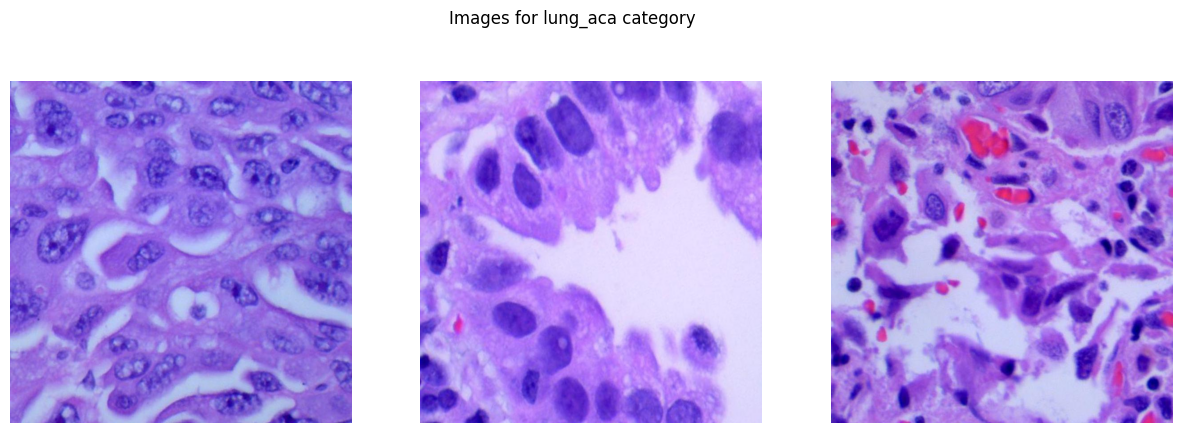

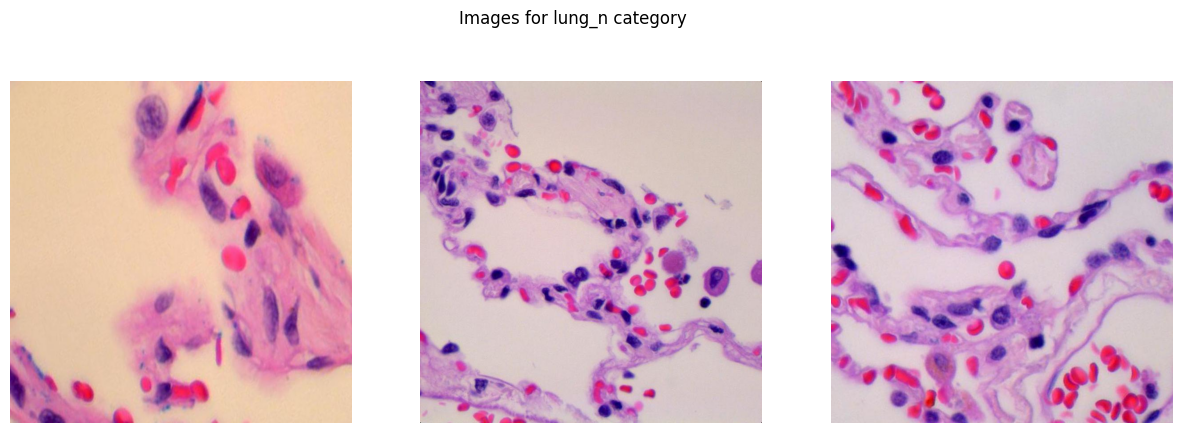

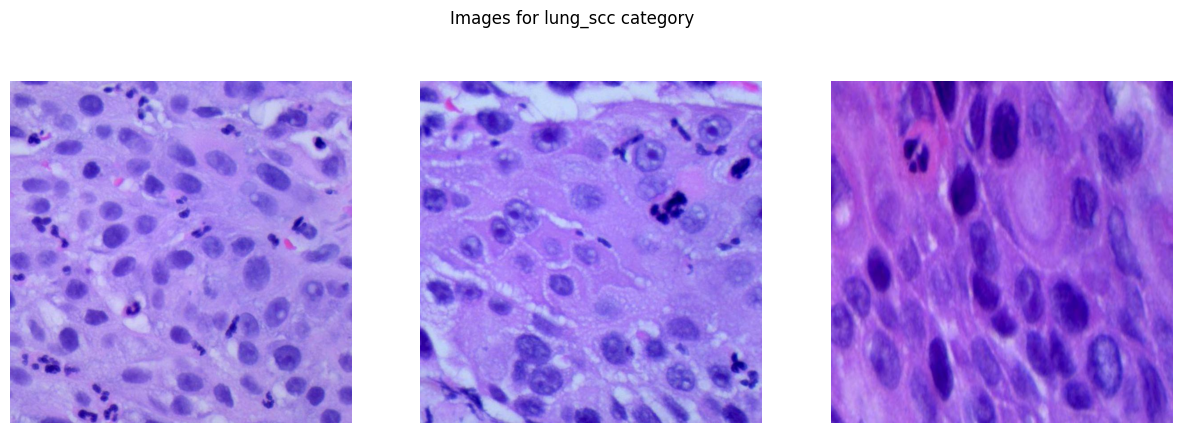

In [5]:
path = 'lung_colon_image_set/lung_image_sets'
classes = ['lung_aca', 'lung_n', 'lung_scc']

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    fig.suptitle(f'Images for {cat} category')

    for i in range(3):
        k = np.random.randint(0, len(images))
        # img = (cv2.imread(f'{image_dir}/{images[k]}', cv2.COLOR_BGR2RGB))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [25]:
IMG_SIZE = 256
EPOCHS = 10
BATCH_SIZE = 64
SEED = 42

# X = []
# Y = []

# for i, cat in enumerate(classes):
#     images = glob.glob(f'{path}/{cat}/*.jpeg')

#     for image in images:
#         img = cv2.imread(image)
#         X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
#         Y.append(i)

train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    validation_split=0.2,
    subset='training',
    seed=SEED,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    shuffle=True
)

class_names = train_ds.class_names
print("Classes:", class_names)
num_classes = len(class_names)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.
Classes: ['lung_aca', 'lung_n', 'lung_scc']


In [7]:
def normalize(x,y):
    x = tf.cast(x, tf.float32)/255.0
    return x,y

train_ds = (train_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
           .prefetch(tf.data.AUTOTUNE))
val_ds = (val_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
           .prefetch(tf.data.AUTOTUNE))

In [8]:
# for i in range(5):
#     print(f"Image {i} shape: {X[i].shape}, dtype: {X[i].dtype}")

In [9]:
# print(X[0].shape)

In [10]:
# X = np.asarray(X)

In [11]:
# X[0].shape

In [12]:
# print(Y)

In [13]:
# one_hot_encoded_Y = pd.get_dummies(Y).astype(int).values

In [14]:
# print(one_hot_encoded_Y)

In [15]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size=0.2, random_state=2022)

In [16]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [17]:
def make_model():
    model = keras.models.Sequential([
        # layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        
        layers.Conv2D(
            filters=32,
            kernel_size = (5,5),
            activation = 'relu',
            input_shape = (IMG_SIZE, IMG_SIZE, 3), #IMG_SIZE = 256
            padding = 'same'
        ),
        layers.MaxPooling2D(2,2),
        
        layers.Conv2D(
            filters=64,
            kernel_size= (3,3),
            activation = 'relu',
            padding='same'
        ),
        layers.MaxPooling2D(2,2),
    
        layers.Conv2D(
            filters = 128,
            kernel_size = (3,3),
            activation = 'relu',
            padding = 'same'
        ),
        layers.MaxPooling2D(2,2),
    
        # layers.Flatten()
        layers.GlobalAveragePooling2D(), 
        layers.Dense(256, activation = 'relu'),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(3, activation='softmax')
    ])
    return model

# model.summary()

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

tensorboard_callback = TensorBoard(log_dir='logs', histogram_freq=1)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto 90% so, stopping further training')
            self.model.stop_training = True

es = EarlyStopping(
    monitor = 'val_loss', 
    restore_best_weights=True
)

ler = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience=2, 
    factor=0.5, 
    verbose=1
)

mc = ModelCheckpoint(
    "best.keras",
    save_best_only=True,
    monitor='val_loss'
)

callbacks = [
    es,            
    mc,            
    myCallback(),  
    ler 
]

In [19]:
lrs = [1e-3, 5e-4, 1e-4]
histories = {}

In [20]:
for lr in lrs:
    model = make_model()
    adam = tf.keras.optimizers.Adam(lr)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    history = model.fit(train_ds, 
                       validation_data = val_ds,
                       epochs = EPOCHS,
                       verbose=1,
                       callbacks=[es, ler,mc, myCallback()]
                                  )
    histories[lr] = history.history


Epoch 1/10


C:\Users\Ankit Regmi\anaconda3\envs\tf_notebook\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.8457 - loss: 0.3758 - val_accuracy: 0.3213 - val_loss: 1.4333 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.8945 - loss: 0.2544 - val_accuracy: 0.6443 - val_loss: 1.1972 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.9136 - loss: 0.2138 - val_accuracy: 0.5507 - val_loss: 0.9633 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.9200 - loss: 0.1987 - val_accuracy: 0.4533 - val_loss: 7.1320 - learning_rate: 0.0010
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.8610 - loss: 0.3502 - val_accuracy: 0.3213 - val_loss: 1.1237 - learning_rate: 5.0000e-04
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.9090 - loss: 0.2367 - val_accuracy: 0.6353 - val_loss: 0.6268 - learning_rate: 5.0000e-04
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.9148 - loss: 0.215

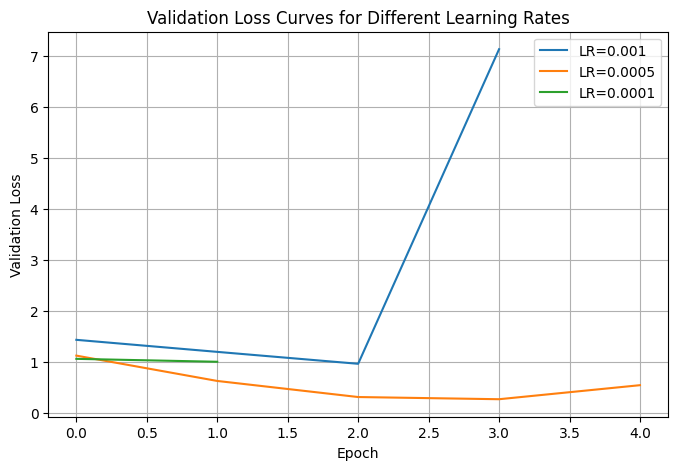

In [21]:
plt.figure(figsize=(8,5))
for lr, hist in histories.items():
    plt.plot(hist["val_loss"], label=f"LR={lr}")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curves for Different Learning Rates")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
y_prob = model.predict(val_ds)
y_pred = np.argmax(y_prob, axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 356ms/step


In [23]:
y_true = []
for _, labels in val_ds:
    y_true.extend(labels.numpy()) 
y_true = np.array(y_true)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred, target_names=val_ds.class_names))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

    lung_aca       0.32      1.00      0.49       964
      lung_n       0.60      0.00      0.01       999
    lung_scc       0.00      0.00      0.00      1037

    accuracy                           0.32      3000
   macro avg       0.31      0.33      0.16      3000
weighted avg       0.30      0.32      0.16      3000

[[ 962    2    0]
 [ 996    3    0]
 [1037    0    0]]


C:\Users\Ankit Regmi\anaconda3\envs\tf_notebook\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ankit Regmi\anaconda3\envs\tf_notebook\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ankit Regmi\anaconda3\envs\tf_notebook\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

Model Prediction

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
def predict_one_image(path):
    img = tf.keras.utils.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    x   = tf.keras.utils.img_to_array(img)
    x   = np.expand_dims(x, axis=0).astype("float32")
    x = tf.cast(x, tf.float32)/255.0
    probs = model.predict(x, verbose=0)
    idx = int(np.argmax(probs, axis=1)[0])
    return {"label": class_names[idx], "prob": float(probs[0, idx]), "raw": probs.tolist()}